## Run specified BCN model and 'drug experiments'


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import h5py
import pandas as pd
import pickle as pkl


import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
from statsmodels.stats.stattools import durbin_watson

import time

### 
import sys 
sys.path.append("..")
from utils import get_data
import os
from os.path import join


# get model

from training import train

# BCN
from models import FullBCModel


# ttest 
from scipy.stats import ttest_rel

from utils_dissection import * 

In [2]:
"""
modify model for tracking
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils import WeightInitialization, get_iGluSnFR_kernel, \
    precomputed_sigmoid
from models import *

class FullBCModel(nn.Module):
    def __init__(
        self,
        cell_types=np.concatenate(
            [np.ones(5) * -1, np.ones(9)]),  # 1=On, -1=OFF cell
        sigmoid_slope_init=15.0,  # float or torch tensor
        sigmoid_offset_init=0.5,
        change_prob01_init=1e-1,
        change_prob12_init=1e-1,
        intermediate_pool_capacity_init=50.0,
        release_pool_capacity_init=10.0,
        input_frequency=64,  # in Hz
        steady_state_steps=0,  # in seconds
        ip_steady=np.ones(14),  # intermediate pool, full at start fraction
        rrp_steady=np.ones(14),  # ready release pool
        noise_init_scale=1e-2,
        kernel_speed_init=1,
        random_init=True,
        seed=1234,
        fit_linear_filter=True,
        fit_non_linearity=True,
        fit_release_parameters=True,
        fit_steady_state=False,
        # local AC feedback
        num_acl=10,  # number of local (glycinergic) amacrine cells
        bc_acl_weight_init=1 / 14,
        acl_tau_rise_init=0.1,
        acl_tau_decay_init=0.1,
        acl_sigmoid_slope_init=2.0,
        acl_sigmoid_offset_init=1.5,
        acl_bc_weight_init=1e-2,
        # global AC feedback
        num_acg=35,  # number of global (gabaergic) amacrine cells
        bc_acg_weight_init=1 / 14,
        acg_tau_rise_init=0.1,
        acg_tau_decay_init=0.1,
        acg_sigmoid_slope_init=2.0,
        acg_sigmoid_offset_init=1.5,
        acg_bc_weight_init=1e-2,
        acl_acg_weight_init=1e-2,
        initial_affine=True,
    ):
        super().__init__()

        # General Static Parameters
        self.num_bc = cell_types.shape[0]
        self.cell_types = torch.nn.Parameter(
            data=torch.tensor(cell_types.astype(np.float32)),
            requires_grad=False)
        self.input_frequency = input_frequency
        self.iglusnfr_kernel = torch.nn.Parameter(
            data=torch.tensor(get_iGluSnFR_kernel(dt=1 / input_frequency)),
            requires_grad=False)
        self.kernel_0_size = len(np.arange(0, 0.3, 1 / self.input_frequency))
        self.kernel_1_size = self.iglusnfr_kernel.shape[-1]
        self.steady_state_steps = steady_state_steps * self.input_frequency
        self.padding = self.steady_state_steps
        self.padding += self.kernel_0_size - 1
        self.padding += self.kernel_1_size - 1
        self.noise_init_scale = noise_init_scale

        ### Local Model ###
        self.initializer = WeightInitialization(
            shape=self.num_bc, noise_init_scale=self.noise_init_scale,
            random=random_init, seed=seed)

        # Feedforward Drive
        self.initial_affine = initial_affine
        if initial_affine:
            self.stimulus_bias = self.initializer.initialize(
                0, shape=1, scale='lin', requires_grad=fit_non_linearity,
                random=fit_non_linearity)
            self.stimulus_scale = self.initializer.initialize(
                0, shape=1, scale='lin', requires_grad=fit_non_linearity,
                random=fit_non_linearity)
        self.log_kernel_speed = self.initializer.initialize(
            kernel_speed_init, requires_grad=fit_linear_filter,
            random=fit_linear_filter)

        # Non-linearity
        self.sigmoid_offset = self.initializer.initialize(
            sigmoid_offset_init, scale='lin', requires_grad=fit_non_linearity,
            random=fit_non_linearity)
        self.log_sigmoid_slope = self.initializer.initialize(
            sigmoid_slope_init, requires_grad=fit_non_linearity,
            random=fit_non_linearity)

        # Release Machinery
        self.log_change_prob01 = self.initializer.initialize(
            change_prob01_init, requires_grad=fit_release_parameters,
            random=fit_release_parameters)
        self.log_change_prob12 = self.initializer.initialize(
            change_prob12_init, requires_grad=fit_release_parameters,
            random=fit_release_parameters)
        self.log_intermediate_pool_capacity = self.initializer.initialize(
            intermediate_pool_capacity_init,
            requires_grad=fit_release_parameters,
            random=fit_release_parameters)
        self.log_release_pool_capacity = self.initializer.initialize(
            release_pool_capacity_init, requires_grad=fit_release_parameters,
            random=fit_release_parameters)
        self.sig_ip_steady = self.initializer.initialize(
            ip_steady, requires_grad=fit_steady_state, scale='sig',
            random=fit_steady_state)
        self.sig_rrp_steady = self.initializer.initialize(
            rrp_steady, requires_grad=fit_steady_state, scale='sig',
            random=fit_steady_state)

        # Feedback
        self.num_acl = num_acl
        self.glycinergic_amacrine_cells = AmacrineCellFeedback(
            bc_acl_weight_init * np.ones((self.num_acl, self.num_bc)),
            acl_tau_rise_init,
            acl_tau_decay_init,
            acl_sigmoid_slope_init,
            acl_sigmoid_offset_init,
            noise_init_scale=self.noise_init_scale,
            input_frequency=self.input_frequency,
            random_init=random_init,
            seed=seed,
        )
        self.log_acl_bc_weight = self.initializer.initialize(
            acl_bc_weight_init * np.ones((self.num_bc, self.num_acl)),
            random=random_init)

        ### Global Model ###
        self.num_acg = num_acg
        self.gabaergic_amacrine_cells = AmacrineCellFeedback(
            bc_acg_weight_init * np.ones((self.num_acg, self.num_bc)),
            acg_tau_rise_init,
            acg_tau_decay_init,
            acg_sigmoid_slope_init,
            acg_sigmoid_offset_init,
            noise_init_scale=self.noise_init_scale,
            input_frequency=self.input_frequency,
            random_init=random_init,
            seed=seed,
        )
        self.log_acg_bc_weight = self.initializer.initialize(
            acg_bc_weight_init * np.ones((self.num_bc, self.num_acg)),
            random=random_init)
        self.bcn_sigmoid_offset = self.initializer.initialize(
            np.zeros(self.num_bc), scale='lin', random=random_init)
        self.log_acl_acg_weight = self.initializer.initialize(
            acl_acg_weight_init * np.ones((self.num_acg, self.num_acl)),
            random=random_init)

    def forward(self, x):
        """
        :param x: raw light input dim: D
        :return:
        """
        
        # linear filtering of light input with biphasic kernel
        x = self.linear_filter(x)  # DC

        # initialize release machinery and tracking
        lnr_state = self.init_state(x)
        bcn_state = self.init_state(x)

        # precompute log weights (compute before loop for speed up)
        sigmoid_slope = torch.exp(self.log_sigmoid_slope)
        # LNR
        acl_bc_weight = - torch.exp(self.log_acl_bc_weight)
        bc_acl_weight = torch.exp(
            self.glycinergic_amacrine_cells.log_bc_ac_weight)
        acl_kernel = self.glycinergic_amacrine_cells.compute_ac_kernel()
        acl_sigmoid_slope = torch.exp(
            self.glycinergic_amacrine_cells.log_ac_sigmoid_slope)
        # BCN
        acg_bc_weight = - torch.exp(self.log_acg_bc_weight)
        bc_acg_weight = torch.exp(
            self.gabaergic_amacrine_cells.log_bc_ac_weight)
        acg_kernel = self.gabaergic_amacrine_cells.compute_ac_kernel()
        acg_sigmoid_slope = torch.exp(
            self.gabaergic_amacrine_cells.log_ac_sigmoid_slope)
        acl_acg_weight = - torch.exp(self.log_acl_acg_weight)
        bcn_sigmoid_offset = self.sigmoid_offset + self.bcn_sigmoid_offset
        
        # tracking of acl_acg_feedback
        track_acl_acg = []
        
        for i, xi in enumerate(x):  # over time steps
            # Local Chirp
            lnr_state['track_ac_input'].append(
                lnr_state['track_release'][i - 1])
            ac_in = torch.stack(  # only relevant history
                lnr_state['track_ac_input'][-acl_kernel.shape[1]:], dim=1)
            acl_out = self.glycinergic_amacrine_cells.forward(
                ac_in, bc_acl_weight, acl_kernel, acl_sigmoid_slope)
            lnr_state['track_acl_output'].append(acl_out)
            local_feedback = torch.matmul(acl_bc_weight, acl_out)  # (nBC)
            lnr_state['track_feedback'][i] = local_feedback
            local_release_prob = precomputed_sigmoid(
                xi + local_feedback, self.sigmoid_offset, sigmoid_slope)
            lnr_state = self.release_step(i, local_release_prob, lnr_state)

            # Global Chirp
            bcn_state['track_ac_input'].append(
                bcn_state['track_release'][i - 1])
            ac_in = torch.stack(  # only relevant history
                bcn_state['track_ac_input'][-acg_kernel.shape[1]:], dim=1)
            acl_out = self.glycinergic_amacrine_cells.forward(
                ac_in, bc_acl_weight, acl_kernel, acl_sigmoid_slope)
            bcn_state['track_acl_output'].append(acl_out)
            global_feedback = torch.matmul(acl_bc_weight, acl_out)
            acg_out = self.gabaergic_amacrine_cells.forward(
                ac_in, bc_acg_weight, acg_kernel, acg_sigmoid_slope)
            acg_out = acg_out + torch.matmul(acl_acg_weight, acl_out)
            bcn_state['track_acg_output'].append(acg_out)
            track_acl_acg.append(torch.matmul(acl_acg_weight, acl_out))
            global_feedback = global_feedback + torch.matmul(
                acg_bc_weight, acg_out)  # (nBC)
            bcn_state['track_feedback'][i] = global_feedback
            global_release_prob = precomputed_sigmoid(
                xi + global_feedback, bcn_sigmoid_offset, sigmoid_slope)
            bcn_state = self.release_step(i, global_release_prob, bcn_state)

        # final iGluSNFR filter and normalization
        y_lnr = self.final_transformation(lnr_state['track_release'])
        y_bcn = self.final_transformation(bcn_state['track_release'])

        return y_lnr, lnr_state, y_bcn, bcn_state, track_acl_acg

    def linear_filter(self, x):
        """
        linear part of the LNR model
        :param x: raw light stimulus
        :return: with kernel convolved trace
        """
        x = F.pad(x, (self.padding, 0),
                  mode='constant', value=x[0])
        if self.initial_affine:
            x = x * self.stimulus_scale
            x = x + self.stimulus_bias
        x = x[None, None, :]  # BCD

        # feedforward drive
        kernel = self.compute_kernel()  # OID
        return F.conv1d(x, kernel)[0].T  # DC

    def final_transformation(self, track_release):
        """
        final convolution with iGlusNFr kernel and affine transformation
        :param track_release:
        :return:
        """
        # convolve with iGluSNFR kernel
        # treat channel as batch dimension, because all get same iGlu kernel.
        # ToDo: change this when using batched inputs!
        x = track_release.T[:, None, :]
        x = F.conv1d(x, self.iglusnfr_kernel)
        x = x[:, 0, self.steady_state_steps:]  # CD

        # normalize (mean=0, norm=1) so correlation can be computed easily
        x = x - torch.mean(x, dim=1, keepdim=True)
        x = x / (torch.norm(x, 2, dim=1, keepdim=True) + 1e-10)
        return x

    def init_state(self, x):
        """
        initializing pool states and compute once what can be outside loop.
        :param release probability.
        :return:
        """
        # fractions steady state [0,1]
        ip_steady = torch.sigmoid(self.sig_ip_steady)
        rrp_steady = torch.sigmoid(self.sig_rrp_steady)

        # capacities minimum 1
        release_pool_capacity = torch.exp(
            self.smooth_clamp(self.log_release_pool_capacity, high=1e6, low=0))
        intermediate_pool_capacity = torch.exp(
            self.smooth_clamp(
                self.log_intermediate_pool_capacity, high=1e6, low=0))

        return dict(
            track_release_prob=torch.zeros_like(x),
            intermediate_pool_state=ip_steady * torch.exp(
                self.log_intermediate_pool_capacity),
            release_pool_state=rrp_steady * torch.exp(
                self.log_release_pool_capacity),
            track_intermediate_pool=torch.zeros_like(x),
            track_release_pool=torch.zeros_like(x),
            track_release=torch.zeros_like(x),
            change_prob12=torch.exp(self.log_change_prob12),
            release_pool_capacity=release_pool_capacity,
            change_prob01=torch.exp(self.log_change_prob01),
            intermediate_pool_capacity=intermediate_pool_capacity,
            track_feedback=torch.zeros_like(x),
            track_ac_input=[],
            track_acl_output=[],
            track_acg_output=[],
        )

    def release_step(self, i, release_prob, state):
        """
        tracking and updating pools for one one release step
        :param i index of release steps
        :param release_prob
        :param state
        :return: updated state
        """
        # track current state of pools
        state['track_release_prob'][i] = release_prob
        state['track_intermediate_pool'][i] = state['intermediate_pool_state']
        state['track_release_pool'][i] = state['release_pool_state']
        state['track_release'][i] = release_prob * state['release_pool_state']

        # update release pool state (actual release) (1/2)
        released = state['release_pool_state'] - state['track_release'][i]

        # update release pool state (refilling) (2/2)
        state['release_pool_state'] = self.smooth_clamp(
            released + state['change_prob12'] * state[
                'intermediate_pool_state'], state['release_pool_capacity'])

        # get movement of vesicles from intermediate to release pool
        transfer = state['release_pool_state'] - released

        # update intermediate pool state (1/1)
        state['intermediate_pool_state'] = self.smooth_clamp(
            state['intermediate_pool_state'] + state['change_prob01'] -
            transfer, state['intermediate_pool_capacity'])

        return state

    def smooth_clamp(self, x, high, low=0):
        """
        :param low: lower bound of clamping
        :param high: upper bound of clamping
        :return: smooth clamping
        """
        #x = F.relu(x)  # hard clamp
        x = F.elu(x - low - 1) + low + 1
        x = F.elu(high - 1 - x) - high + 1
        return - x

    def compute_kernel(self):
        """
        PR biphasic kernel
        :return: normalized kernel with dt=1/scan_frequency
        (from https://github.com/berenslab/abc-ribbon/blob/master
        /standalone_model/ribbonv2.py)
        """
        # all variables in sec
        device = self.log_kernel_speed.device
        t = torch.arange(0.3, 0, step=-1 / self.input_frequency).to(device)
        kernel_speed = torch.exp(self.log_kernel_speed)
        t = t[None, :]
        kernel_speed = kernel_speed[:, None]
        tau_r = 0.05 * kernel_speed
        tau_d = 0.05 * kernel_speed
        phi = - np.pi * (0.2 / 1.4) * kernel_speed
        tau_phase = 100
        kernel = - (t / tau_r) ** 3 / (1 + t / tau_r) * torch.exp(
            - (t / tau_d) ** 2) * torch.cos(2 * np.pi * t / phi + tau_phase)
        # set kernel L2 norm = 1
        kernel = kernel / torch.norm(kernel, dim=1, keepdim=True)
        kernel = - kernel * self.cell_types[:, None]
        return kernel[:, None, :]  # out_channel x in_channel x duration

In [3]:
"""
plotting settings
"""
def clean_fig():
    sns.despine( top=True, right=True, left=True, bottom=True, offset=None, trim=False)
    plt.xticks([])
    plt.yticks([])
    
"""
define 14 BC colors
"""  
'''
bc_colors=[]
for i in range(14):
    if i<5:
        bc_colors.append(cm.coolwarm(1-i/10))
    else:
        bc_colors.append(cm.coolwarm(1-(i+5)/18))
    #plt.plot(i,i,'o', color=bc_colors[i])
'''
    

# extracted colors from nature paper
  
def rgb_tuple(h):
    a = tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4)) + (1,)
    return a

hs = ['8a0c15ff',
      'db0b10ff',
      'fa7c20ff',
      'f7a11dff',
      'f0d01dff',
      'c9f599ff',
      '86f582ff',
      '13f50eff',
      '17921bff',
      '19f3f0ff',
      '14a7e4ff',
      '5e0ec9ff',
      '5e0ec9ff',
      '333333ff']
      
bc_colors_nat=[]
for h in hs:
    bc_colors_nat.append(rgb_tuple(h))
      
bc_colors = bc_colors_nat  
    
bc_labels=['BC1',
         'BC2',
         'BC3a',
         'BC3b',
         'BC4',
         'BC5t',
         'BC5o',
         'BC5i',
         'BCX',
         'BC6',
         'BC7',
         'BC8',
         'BC9',
         'BCR']

#### load best models

In [4]:

"""
BCN
"""
model_bcn = FullBCModel()
#model_bcn.load_state_dict(torch.load(file_path+'best_bcn/z_scored_inaff/model.pth'))
file_path_model = '../results/random_search_9/3359087/'

model_bcn.load_state_dict(torch.load(file_path_model+'model.pth'))

<All keys matched successfully>

#### load chirp  data and strychnine

In [5]:
"""
Load data
returns: (X_local, X_global, chirp, types, sampling_frequency, exp_time,
            local_m, local_sd, global_m, global_sd)
"""
X_local, X_global, chirp, types, sampling_frequency, *_  = get_data(normalize=True,data_dir='../data' )

x_train = chirp
x_train_tensor = torch.tensor(x_train,  dtype=torch.float32)
y_train = np.vstack([X_global,X_local])


#modify stimulus to have longer adaptation

ntpts = 10*64
x_train_long = np.hstack((np.ones(ntpts)*x_train[0], x_train, ))
x_train_long_tensor = torch.tensor(x_train_long,dtype=torch.float32)



# loading strychnine data
file_path = '../data/'

with open(file_path+"Franke_etal_strychnine_traces.pkl", "rb") as f:
    strychnine_traces = pkl.load(f)

celltypes_strychnine = {0: 'NO',
 1: 'BC1',
 2: 'BC2',
 3: 'BC3a',
 4: 'BC3b',
 5: 'BC4',
 6: 'BC5t',
 7: 'BC5o',
 8: 'BC5i',
 9: 'BCX',
 10: 'BC6',
 11: 'BC7',
 12: 'BC8',
 13: 'BC9',
 14: 'BCR'}

celltypes_strychnine_to_nr = { 'BC1': 0,
 'BC2': 1,
 'BC3a': 2,
 'BC3b': 3,
 'BC4': 4,
 'BC5t': 5,
 'BC5o': 6,
 'BC5i': 7,
 'BCX': 8,
  'BC6': 9,
  'BC7': 10,
  'BC8': 11,
  'BC9': 12,
 'BCR': 13}

### run models on x_train

In [6]:

"""
run BCN
"""
# returns: y_lnr, lnr_state, y_bcn, bcn_state
out_bcn_train = model_bcn.forward(x_train_tensor)

(0.8, 1)

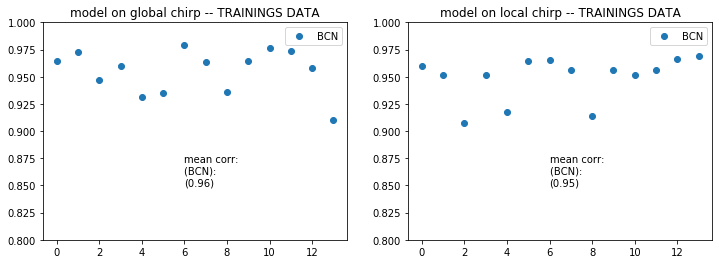

In [14]:
"""
compute and plot training loss
"""
#compute correlations
corr_bcn_train = np.hstack([get_corr_train(out_bcn_train[2],y_train[:14]), # global
                            get_corr_train(out_bcn_train[0],y_train[14:])]) #local

#####################################

plt.figure(1, figsize=(12,4))
plt.subplot(121)
plt.title('model on global chirp -- TRAININGS DATA')
plt.plot(corr_bcn_train[:14], 'o',label='BCN')

plt.legend()

plt.text(6,0.85,'mean corr: \n(BCN): \n({})'.format(np.mean(corr_bcn_train[:14]).round(2)))
plt.ylim(0.8,1)

plt.subplot(122)
plt.title('model on local chirp -- TRAININGS DATA')
plt.plot(corr_bcn_train[14:], 'o',label='BCN')

plt.legend()

plt.text(6,0.85,'mean corr: \n(BCN): \n({})'.format(np.mean(corr_bcn_train[14:]).round(2)))

plt.ylim(0.8,1)

### construct  testing step stimulus

adaption tpts: 576


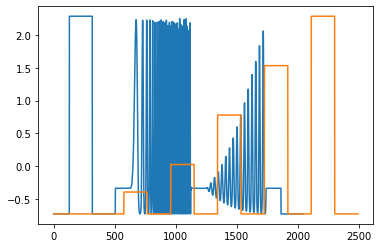

In [292]:
"""
create testing stimulus: multiple steps
"""

# extract values from normalized chirp stimulus 
chirp_baseline = chirp[0]
chirp_max = np.max(chirp)
chirp_small_step = chirp[550]
chirp_max_diff = np.max(chirp)-np.min(chirp)
adaption_tpts = 192*3#np.argmax(chirp>chirp_baseline)
print('adaption tpts:',adaption_tpts)

x_test = np.ones(13*192)*chirp_baseline
# 3 sec steps with 3 sec baseline in between
x_test[adaption_tpts:adaption_tpts+192] = -chirp_small_step+ chirp_baseline #chirp_small_step
x_test[adaption_tpts+192*2:adaption_tpts+192*3] =chirp_max_diff/4 + chirp_baseline
x_test[adaption_tpts+192*4:adaption_tpts+192*5] = chirp_max_diff/2 + chirp_baseline
x_test[adaption_tpts+192*6:adaption_tpts+192*7] =  3*chirp_max_diff/4 + chirp_baseline 
x_test[adaption_tpts+192*8:adaption_tpts+192*9] =  chirp_max


plt.plot(chirp)
plt.plot(x_test)


# Drug experiments

## Glycin blocking: strychnin

In [16]:
"""
BCN
"""

model_bcn_drug_strychnine = FullBCModel()

model_bcn_drug_strychnine.load_state_dict(torch.load(file_path_model+'model.pth'))

# mean of feedback from training data
mean_local_fb = torch.mean(out_bcn_train[1]['track_feedback'].detach(), dim=0)
mean_global_fb = torch.mean(out_bcn_train[3]['track_feedback'].detach(), dim=0)

# only works with modified model below:
mean_acl_acg_feedback = torch.matmul(torch.exp(model_bcn.log_acg_bc_weight), 
                                torch.stack(out_bcn_train[4]).mean(axis=0)).detach()

"""
modify parameter
"""

# strychnin experiment: blocking glycin AC
model_bcn_drug_strychnine.log_acl_acg_weight.data =  -torch.ones((35,10))*1e10 
model_bcn_drug_strychnine.log_acl_bc_weight.data =  -torch.ones((14,10))*1e10 


#model_bcn_drug_strychnine.sigmoid_offset.data = model_bcn_drug_strychnine.sigmoid_offset.data - mean_local_fb
#model_bcn_drug_strychnine.bcn_sigmoid_offset.data = model_bcn_drug_strychnine.bcn_sigmoid_offset.data + mean_acl_acg_feedback

"""
run model
"""
# returns: y_lnr, lnr_state, y_bcn, bcn_state
out_bcn_drug_strychnine = model_bcn_drug_strychnine.forward(x_train_long_tensor)


"""
get unnormalized responses
"""
# final iGluSNFR filter 
out_bc_drug_strychnine_unnorm = [final_transformation(out_bcn_drug_strychnine[3]['track_release'],  model_bcn.iglusnfr_kernel),
                     final_transformation(out_bcn_drug_strychnine[1]['track_release'],  model_bcn.iglusnfr_kernel)]
out_bc_train_unnorm = [final_transformation(out_bcn_train[3]['track_release'],  model_bcn.iglusnfr_kernel),
                       final_transformation(out_bcn_train[1]['track_release'],  model_bcn.iglusnfr_kernel)]

corr control: 0.8202797755072987
corr drug: 0.6559346476617948
t test for all traces:    Ttest_relResult(statistic=2.3436355542652505, pvalue=0.035646340737563745)


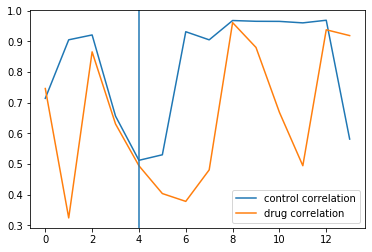

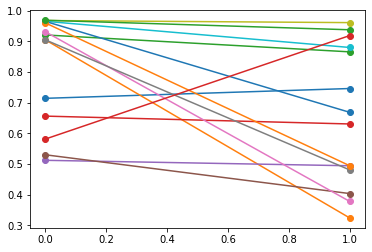

correlations for off traces:
corr control: 0.7416470217966527
corr drug: 0.6120860440848115


In [164]:
"""
get correlation of control and drug 

# correlation should go DOWN in blocked condition
"""
corr_control = get_corr_train(out_bcn_train[0].detach(), out_bcn_train[2].detach())
corr_control_data = get_corr_train(X_global, X_local)

corr_drug_strychnine = get_corr_train(out_bcn_drug_strychnine[0].detach()[:,640:], out_bcn_drug_strychnine[2].detach()[:,640:])

print('corr control:',np.mean(corr_control))
print('corr drug:',np.mean(corr_drug_strychnine))
print('t test for all traces:   ', ttest_rel(corr_control, corr_drug))

#plt.plot(corr_control_data, label='control_data')

plt.plot(corr_control, label='control correlation')
plt.plot(corr_drug_strychnine, label='drug correlation')
plt.axvline(4)
plt.legend()
plt.show()

plt.plot(np.stack([corr_control, corr_drug_strychnine])[:,:], 
         marker='o')
plt.show()

print('correlations for off traces:')
print('corr control:',np.mean(corr_control[:5]))
print('corr drug:',np.mean(corr_drug_strychnine[:5]))



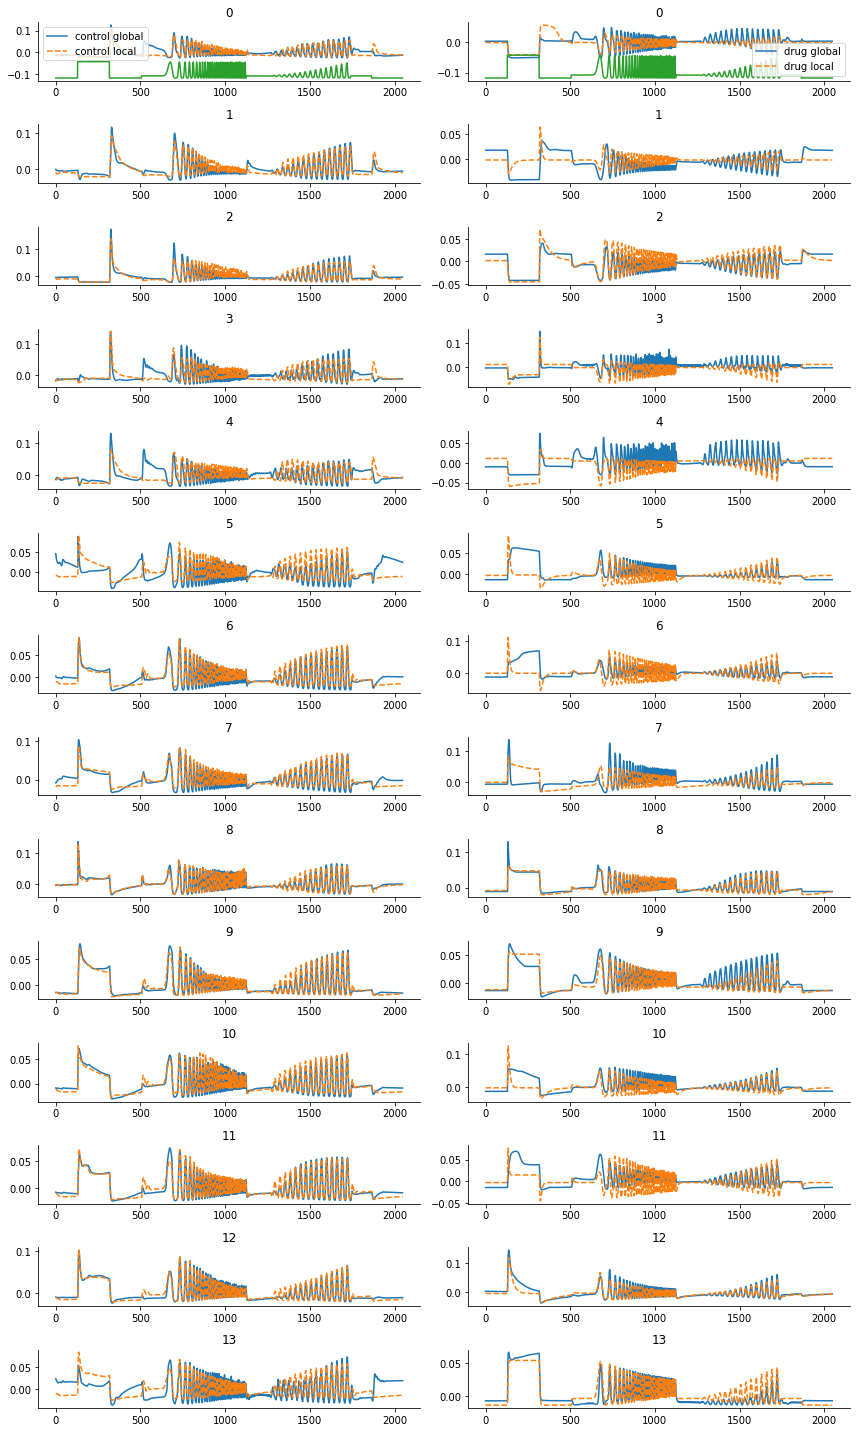

In [18]:
plt.figure(1,figsize=(12,20))
for i in range(14):
    plt.subplot(14,2,i*2+1)
    plt.title(i)
    ## unnormalized
    #plt.plot(out_bc_train_unnorm[0][i].detach(), label='control global')
    #plt.plot(out_bc_train_unnorm[1][i].detach(), label='control local', ls='--')
    
    
    ## normalized
    plt.plot(out_bcn_train[2][i].detach(), label='control global')
    plt.plot(out_bcn_train[0][i].detach(), label='control local', ls='--')
    #plt.plot(X_global[i])
    if i==0:
        plt.legend()
        plt.plot(chirp/40-0.1)
        
    ####    
    plt.subplot(14,2,i*2+2)
    plt.title(i)
    # unnormalized
    #plt.plot(out_bc_drug_unnorm[0][i].detach(), label='drug global')
    #plt.plot(out_bc_drug_unnorm[1][i].detach(), label='drug local', ls='--')
    ## normalized
    plt.plot(out_bcn_drug_strychnine[2][i].detach()[640:], label='drug global')
    plt.plot(out_bcn_drug_strychnine[0][i].detach()[640:], label='drug local', ls='--')
    
    
    if i==0:
        plt.legend()
        plt.plot(chirp/40-0.1)

plt.tight_layout()
sns.despine()

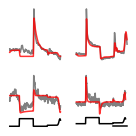

In [151]:
"""
nice plot for 'reducing local features'
"""

save = False
plot_legend = True#not save

datacolor='grey'
modelcolor='r'

#ylims=[-3,5]

stimtime = np.arange(0,len(X_global[4]))/64

"""
extract data from two cells
"""

celltype='BC4'
i=celltypes_strychnine_to_nr[celltype]

trace_local = z_score(X_local[i])
trace_global = z_score(X_global[i])
trace_drug_local = z_score(np.mean(strychnine_traces['lchirp'][celltypes_strychnine[i+1]], axis=0))
#trace_drug_local_std = z_score(np.std(strychnine_traces['lchirp'][celltypes_strychnine[i+1]], axis=0))
trace_drug_global = z_score(np.mean(strychnine_traces['gchirp'][celltypes_strychnine[i+1]], axis=0))

model_local = z_score(np.array(out_bcn_train[0][i].cpu().detach()))
model_global = z_score(np.array(out_bcn_train[2][i].cpu().detach()))
model_drug_local = z_score(np.array(out_bcn_drug_strychnine[0][i].cpu().detach())[640:])
model_drug_global = z_score(np.array(out_bcn_drug_strychnine[2][i].cpu().detach())[640:])

#####################################

celltype='BC5o'
i2=celltypes_strychnine_to_nr[celltype]
trace_local2 = z_score(X_local[i2])
trace_global2 = z_score(X_global[i2])
trace_drug_local2 = z_score(np.mean(strychnine_traces['lchirp'][celltypes_strychnine[i2+1]], axis=0))
#trace_drug_local_std2 = z_score(np.std(strychnine_traces['lchirp'][celltypes_strychnine[i2+1]], axis=0))
trace_drug_global2 = z_score(np.mean(strychnine_traces['gchirp'][celltypes_strychnine[i2+1]], axis=0))

model_local2 = z_score(np.array(out_bcn_train[0][i2].cpu().detach()))
model_global2 = z_score(np.array(out_bcn_train[2][i2].cpu().detach()))
model_drug_local2 = z_score(np.array(out_bcn_drug_strychnine[0][i2].cpu().detach())[640:])
model_drug_global2 = z_score(np.array(out_bcn_drug_strychnine[2][i2].cpu().detach())[640:])

#################################

# get ylims for plotting
max_plot = np.max([model_local.max(),model_drug_local.max(),
                   trace_local.max(), trace_local.max(),
                   model_local2.max(),model_drug_local2.max(),
                   trace_local2.max(), trace_local2.max()
                  ])
min_plot = np.min([model_local.min(),model_drug_local.min(),
                   trace_local.min(), trace_local.min(),
                   model_local2.min(),model_drug_local2.min(),
                   trace_local2.min(), trace_local2.min()
                  ])

ylims=[None,None]

plt.figure(1, figsize=(2,2))
alpha=0.8
S0 = 0
S = int(10.7 *64)

plt.subplot(2,2,1)
#plt.title('first dip: '+celltypes_strychnine[i+1])
#plt.plot(stimtime[S0:S], trace_global[S0:S])
#plt.plot(stimtime[S0:S],model_global[S0:S], alpha=1)
plt.plot(stimtime[S0:S],trace_local[S0:S], label='data local', color=datacolor)
plt.plot(stimtime[S0:S],model_local[S0:S], label='model local', color=modelcolor, alpha=alpha)
if plot_legend:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(ylims)
clean_fig()


plt.subplot(2,2,3)
#plt.plot(stimtime[S0:S],trace_drug_global[S0:S])
#plt.plot(stimtime[S0:S],model_global_drug[S0:S])
plt.plot(stimtime[S0:S],trace_drug_local[S0:S],label='drug data local', color=datacolor)
plt.plot(stimtime[S0:S],model_drug_local[S0:S],label='drug model local', color=modelcolor, alpha=alpha)
#plt.fill_between(stimtime[S0:S],
#                 trace_drug_local[S0:S]-trace_drug_local_std[S0:S],
#                 trace_drug_local[S0:S]+trace_drug_local_std[S0:S],
#                 alpha=0.5)

# plot stimulus
plt.plot(stimtime[S0:S],chirp[S0:S]/2-5, color='black')

if plot_legend:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(ylims)
clean_fig()


#################################

#S0=0
#S=11*64
plt.subplot(2,2,2)
#plt.title('local features: '+celltypes_strychnine[i2+1])
#plt.plot(stimtime[S0:S], trace_global2[S0:S])
#plt.plot(stimtime[S0:S],model_global2[S0:S], alpha=1)
plt.plot(stimtime[S0:S],trace_local2[S0:S], label='data local', color=datacolor)
plt.plot(stimtime[S0:S],model_local2[S0:S], label='model local', color=modelcolor, alpha=alpha)
if plot_legend:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(ylims)
clean_fig()




plt.subplot(2,2,4)
#plt.plot(stimtime[S0:S],trace_drug_global2[S0:S])
#plt.plot(stimtime[S0:S],model_global_drug2[S0:S])
plt.plot(stimtime[S0:S],trace_drug_local2[S0:S],label='drug data local', color=datacolor)
plt.plot(stimtime[S0:S],model_drug_local2[S0:S],label='drug model local', color=modelcolor, alpha=alpha)
#plt.fill_between(stimtime[S0:S],
#                 trace_drug_local[S0:S]-trace_drug_local_std[S0:S],
#                 trace_drug_local[S0:S]+trace_drug_local_std[S0:S],
#                 alpha=0.5)

# plot timescale
plt.plot([8,11],[-6,-6], c='black') # 3 sec
#plt.plot([11,11],[-1,1], c='black') # 2std

# plot stimulus
plt.plot(stimtime[S0:S],chirp[S0:S]/2-5, color='black')

if plot_legend:
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(ylims)
clean_fig()

plt.tight_layout()

if save:
    filepath = '../../BC_mechanistic/presenting/fig4/'
    filename = 'drug_features_v2'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')

#### tonic release calculation on chirp strychnin
vgl. Fig 8

local. control vs drug
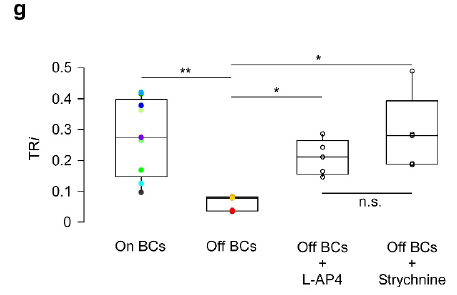

In [95]:
"""
get tonic release indeces 
"""
tri_drug_strychnine_local = get_tonic_releas(out_bc_drug_strychnine_unnorm[1].detach()[:,640:])
tri_control_local = get_tonic_releas(out_bc_train_unnorm[1].detach())

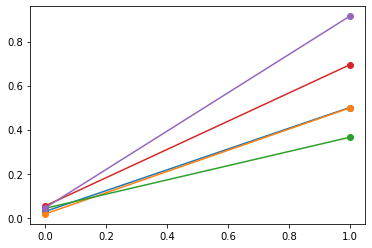

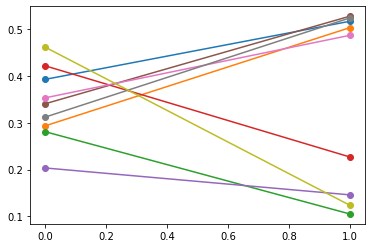

In [96]:
plt.plot(np.stack([tri_control_local,tri_drug_strychnine_local])[:,:5],
        marker='o')
plt.show()
plt.plot(np.stack([tri_control_local,tri_drug_strychnine_local])[:,5:],
        marker='o')

## run model on test_stim (steps)


global/local: 
- down in drug strychnine
- up in gaba


In [360]:
"""
run BCN
"""
x_test_tensor = torch.tensor(x_test,  dtype=torch.float32)

out_bcn_step = model_bcn.forward(x_test_tensor)
out_bcn_drug_step = model_bcn_drug_strychnine(x_test_tensor) 

"""
get unnormalized responses
"""
# final iGluSNFR filter 
step_test_unnorm = [final_transformation(out_bcn_drug_step[3]['track_release'],  model_bcn.iglusnfr_kernel),
                     final_transformation(out_bcn_drug_step[1]['track_release'],  model_bcn.iglusnfr_kernel)]

step_control_unnorm = [final_transformation(out_bcn_step[3]['track_release'],  model_bcn.iglusnfr_kernel),
                       final_transformation(out_bcn_step[1]['track_release'],  model_bcn.iglusnfr_kernel)]

In [387]:
"""
calc max responses
"""
normalize = True

#adaption_tpts = 576


# on normalized traces
if normalize:
    max_act_control_global=get_max_activation(out_bcn_step[2].detach() )
    max_act_control_local=get_max_activation(out_bcn_step[0].detach())

    max_act_test_global=get_max_activation(out_bcn_drug_step[2].detach())
    max_act_test_local=get_max_activation(out_bcn_drug_step[0].detach())

# on unnormalized traces
else:
    max_act_control_global=get_max_activation(step_control_unnorm[0].detach() )
    max_act_control_local=get_max_activation(step_control_unnorm[1].detach())

    max_act_test_global=get_max_activation(step_test_unnorm[0].detach())
    max_act_test_local=get_max_activation(step_test_unnorm[1].detach())


    
# calc ratio
c=0.01
ratio_test_strychnine = ((max_act_test_global+c)/(max_act_test_local+c))#[:5]
ratio_control = ((max_act_control_global+c)/(max_act_control_local+c))#[:5]


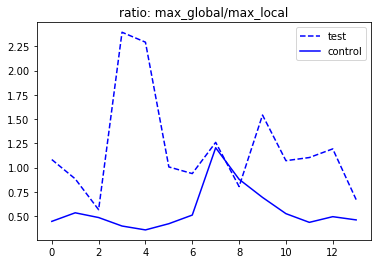

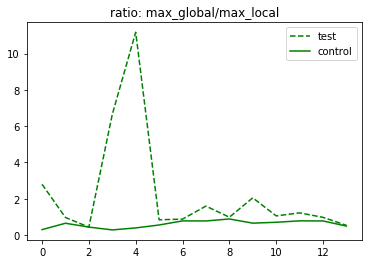

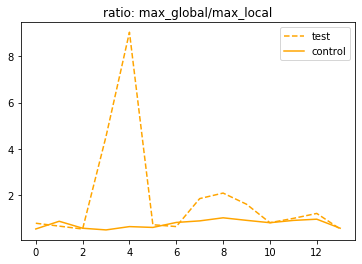

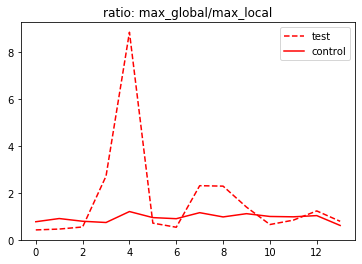

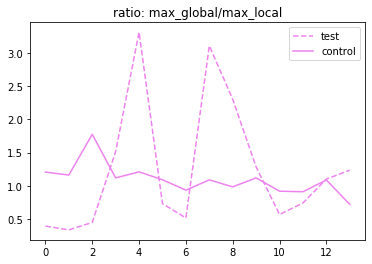

In [388]:
colors=['blue','green','orange','red', 'violet']
for i in range(5):
    plt.title('ratio: max_global/max_local')
    plt.plot(ratio_test_strychnine.T[i], 
             color=colors[i],
             ls='--',
            label='test')
    plt.plot(ratio_control.T[i], 
             color=colors[i],
            ls='-',
            label='control')
    plt.legend()
    plt.show()

0.8648604878543551
0.855578340268941


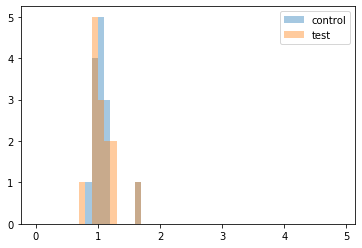

In [386]:
step_nr = 4

filter1 = ratio_test.flatten()>-10
filter2 = ratio_control.flatten()>-10


bins = np.arange(0,5,0.1)

sns.distplot(ratio_control[:,step_nr].flatten(), 
             kde=False,
            bins = bins,
            label='control')

sns.distplot(ratio_test[:,step_nr].flatten(), 
             kde=False,
            bins = bins,
            label='test')


plt.legend()

print(np.mean(ratio_control))
print(np.mean(ratio_test))


#plt.xlim(0,50)

Text(0, 0.5, 'global / local')

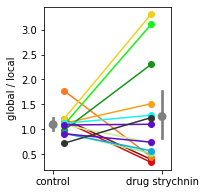

In [389]:

step_nr = 4

save = False

df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']=ratio_control[:,step_nr]
df['type']= None
df['setting'] = ['control']*14

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=ratio_test_strychnine[:,step_nr]
df2['type']=None
df2['setting'] = ['drug strychnin']*14

df = df.append(df2)


plt.figure(1,figsize=(5,3))

#plt.suptitle('tonic release index -- OFF cells')

plt.subplot(121)
ax =  sns.pointplot(x='setting',
                    y='value',
                    data=df, 
                    orient='vertical',
                   width=0.8,
                    color='grey',
                    join=False,
                    order=['control','drug strychnin']
                   )
for i in range(14):
    plt.plot([0.1,0.9], 
             np.stack([ratio_control[:,step_nr],ratio_test_strychnine[:,step_nr] ])[:,i],
            marker='o',
            color=bc_colors[i],
             label=i
            )

plt.xlabel('')
plt.ylabel('')
#plt.legend()

plt.ylabel('global / local')

#plt.ylim(0.5,2.2)
#plt.xlim(-0.1,1.1)

stepnr 4


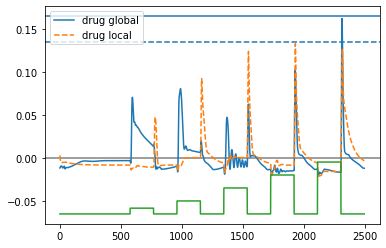

In [385]:
step_nr = 4
i = 0
plt.axhline(max_act_control_global[i,step_nr])
plt.axhline(max_act_control_local[i,step_nr], ls='--')
plt.axhline(0,c='grey')

plt.plot(out_bcn_step[2][i].detach(), label='drug global')
plt.plot(out_bcn_step[0][i].detach(), label='drug local', ls='--')
plt.plot(x_test/50 - 0.05)
plt.legend()
print('stepnr', step_nr)

In [324]:
max_act_control_global[i,step_nr]/max_act_control_local[i,step_nr]

9.8850431127787

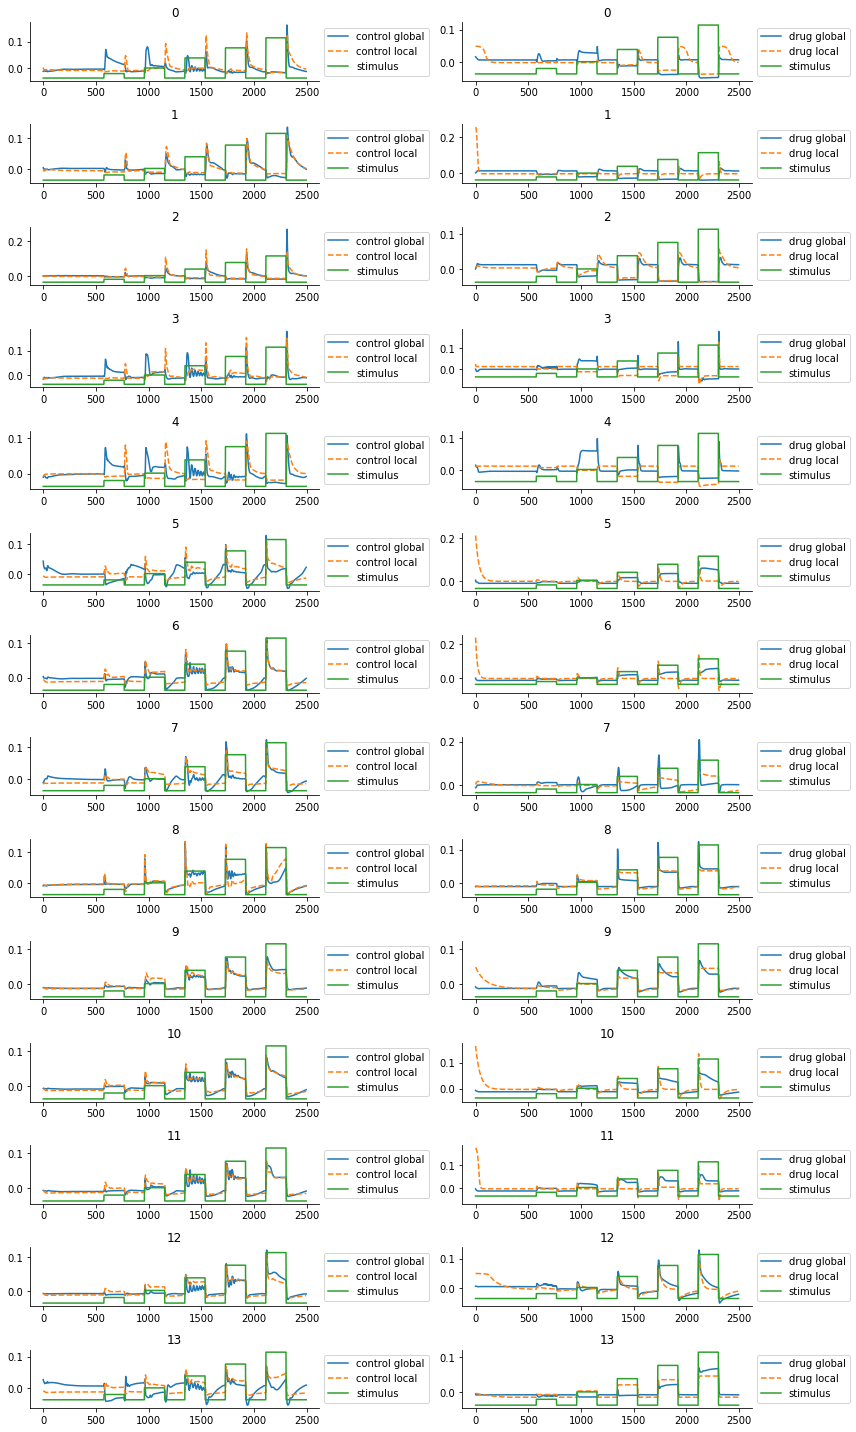

In [304]:
normalize=True

plt.figure(1,figsize=(12,20))
for i in range(14):
    plt.subplot(14,2,i*2+1)
    plt.title(i)
    
    if normalize:
        plt.plot(out_bcn_step[2][i].detach(), label='control global')
        plt.plot(out_bcn_step[0][i].detach(), label='control local', ls='--')
    else:
        plt.plot(step_control_unnorm[0][i].detach(), label='control global')
        plt.plot(step_control_unnorm[1][i].detach(), label='control local', ls='--')
        
    #if i==1:
    plt.plot(x_test/20,
             label='stimulus')
    plt.legend(loc='center left', 
               bbox_to_anchor=(1, 0.5))
        
    plt.subplot(14,2,i*2+2)
    plt.title(i)
    
    if normalize:
        plt.plot(out_bcn_drug_step[2][i].detach(), label='drug global')
        plt.plot(out_bcn_drug_step[0][i].detach(), label='drug local', ls='--')
    else:
        plt.plot(step_test_unnorm[0][i].detach(), label='drug global')
        plt.plot(step_test_unnorm[1][i].detach(), label='drug local', ls='--')
   
    
    # if i==1:
    plt.plot(x_test/20,
            label='stimulus')
    plt.legend(loc='center left', 
               bbox_to_anchor=(1, 0.5))

plt.tight_layout()
sns.despine()

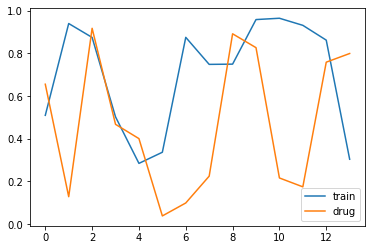

In [112]:
"""
test correlations of steps
"""

corr_step_train = get_corr_train(step_control_unnorm[0].detach(),step_control_unnorm[1].detach())
corr_step_drug = get_corr_train(step_test_unnorm[0].detach(),step_test_unnorm[1].detach())

plt.plot(corr_step_train, label='train')
plt.plot(corr_step_drug, label='drug')
plt.legend()

## drug experiments: Blocking mGluR6 receptors


In [113]:
"""
BCN
"""

model_bcn_drug_mglur6 = FullBCModel()
model_bcn_drug_mglur6.load_state_dict(torch.load(file_path_model+'model.pth'))

"""
modify parameter
"""
# blocking specific ON-input to AC. 
model_bcn_drug_mglur6.glycinergic_amacrine_cells.log_bc_ac_weight.data[:,5:] = -torch.ones((10,9))*1e10 
model_bcn_drug_mglur6.gabaergic_amacrine_cells.log_bc_ac_weight.data[:,5:] =  -torch.ones((35,9))*1e10 

# makes no sense for mglur6?!?!
#model_bcn_drug_mglur6.bcn_sigmoid_offset.data = model_bcn_drug_mglur6.bcn_sigmoid_offset.data - mean_global_fb


"""
run model
"""
# returns: y_lnr, lnr_state, y_bcn, bcn_state
out_bcn_drug_mglur6 = model_bcn_drug_mglur6.forward(x_train_long_tensor)

"""
get unnormalized responses
"""
# final iGluSNFR filter 

drug_mglur6_unnorm = [final_transformation(out_bcn_drug_mglur6[3]['track_release'],  model_bcn.iglusnfr_kernel),
                       final_transformation(out_bcn_drug_mglur6[1]['track_release'],  model_bcn.iglusnfr_kernel)]


"""
calculate tonic index
"""
tri_drug_mglur6_local = get_tonic_releas(drug_mglur6_unnorm[1].detach()[:,640:])


In [253]:
"""
run step responses
"""

x_test_tensor = torch.tensor(x_test,  dtype=torch.float32)

out_bcn_drug_step = model_bcn_drug_gaba(x_test_tensor) 

"""
get unnormalized responses
"""
# final iGluSNFR filter 
step_test_unnorm = [final_transformation(out_bcn_drug_step[3]['track_release'],  model_bcn.iglusnfr_kernel),
                     final_transformation(out_bcn_drug_step[1]['track_release'],  model_bcn.iglusnfr_kernel)]

step_control_unnorm = [final_transformation(out_bcn_step[3]['track_release'],  model_bcn.iglusnfr_kernel),
                       final_transformation(out_bcn_step[1]['track_release'],  model_bcn.iglusnfr_kernel)]


"""
calc max responses
"""
normalize = True

# on normalized traces
if normalize:
    max_act_test_global=get_max_activation(out_bcn_step[2].detach())
    max_act_test_local=get_max_activation(out_bcn_step[0].detach())

# on unnormalized traces
else:
    max_act_test_global=get_max_activation(step_test_unnorm[0].detach())
    max_act_test_local=get_max_activation(step_test_unnorm[1].detach())


    
# calc ratio
c=0.05
ratio_test_gaba = ((max_act_test_global+c)/(max_act_test_local+c))#[:5]


Text(0, 0.5, 'global / local')

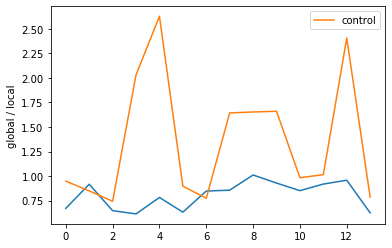

In [254]:
step_nr = 2
plt.plot(ratio_test_gaba[:,step_nr])
plt.plot(ratio_control[:,step_nr], label='control')
plt.legend()
plt.ylabel('global / local')

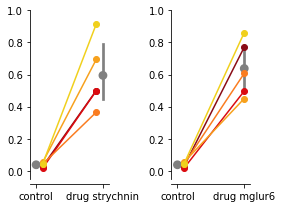

In [153]:
"""
nice plots for OFF cells
"""

save = False

df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']=tri_control_local[:5]
df['type']=['OFF']*5 
df['setting'] = ['control']*5

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=tri_drug_strychnine_local[:5]
df2['type']=['OFF']*5 
df2['setting'] = ['drug strychnin']*5

df3 = pd.DataFrame(columns=['value', 'type', 'setting'])
df3['value']=tri_drug_mglur6_local[:5]
df3['type']=['OFF']*5 
df3['setting'] = ['drug mglur6']*5

df2 = df2.append(df)
df3 = df3.append(df)

plt.figure(1,figsize=(4,3))

#plt.suptitle('tonic release index -- OFF cells')

plt.subplot(121)
ax =  sns.pointplot(x='setting',
                    y='value',
                    data=df2, 
                    orient='vertical',
                   width=0.8,
                    color='grey',
                    join=False,
                    order=['control','drug strychnin']
                   )
for i in range(5):
    plt.plot([0.1,0.9], 
             np.stack([tri_control_local,tri_drug_strychnine_local ])[:,i],
            marker='o',
            color=bc_colors[i],
             label=i
            )

plt.xlabel('')
plt.ylabel('')
plt.yticks([0,0.2,0.4,0.6,0.8,1])
#plt.legend()
ax.spines['bottom'].set_position(('outward', 5))
plt.ylim(-0.05,1)

###################################################
plt.subplot(122)
ax =  sns.pointplot(x='setting',
                    y='value',
                    data=df3 ,
                    orient='vertical',
                   width=0.8,
                    color='grey',
                    join=False,
                     order=['control','drug mglur6']
                   )

for i in range(5):
    plt.plot([0.1,1],
             np.stack([tri_control_local, tri_drug_mglur6_local])[:,i],
            marker='o',
            ls='-',
            color=bc_colors[i],
            label=i)
    
plt.ylim(-0.05,1)
plt.ylabel('TRI')
plt.xlabel('')
sns.despine()
plt.ylabel('')
#plt.legend()
plt.tight_layout()
ax.spines['bottom'].set_position(('outward', 5))

if save:
    filepath = '../../BC_mechanistic/presenting/fig4/'
    filename = 'tri_single_v2'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')
    


In [428]:
p1 = ttest_rel(tri_control_local[:5], tri_drug_strychnine_local[:5])
p2 = ttest_rel(tri_control_local[:5], tri_drug_mglur6_local[:5])

print('p= '+str(p1[1].round(4)))
print('p= '+str(p2[1].round(4)))

p= 0.0039
p= 0.0016


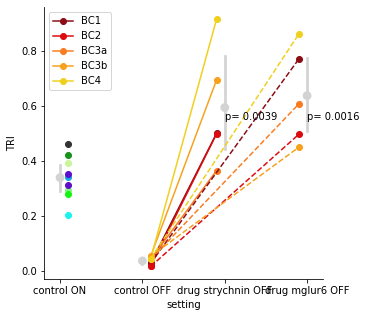

In [118]:
"""
nice plots for OFF cells
"""


save = False

df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']=tri_control_local[:5]
df['type']=['OFF']*5 
df['setting'] = ['control OFF']*5

dfon = pd.DataFrame(columns=['value', 'type', 'setting'])
dfon['value']=tri_control_local[5:]
dfon['type']=['ON']*9
dfon['setting'] = ['control ON']*9

df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']=tri_drug_strychnine_local[:5]
df2['type']=['OFF']*5 
df2['setting'] = ['drug strychnin OFF']*5

df3 = pd.DataFrame(columns=['value', 'type', 'setting'])
df3['value']=tri_drug_mglur6_local[:5]
df3['type']=['OFF']*5 
df3['setting'] = ['drug mglur6 OFF']*5

df = df.append(df2)
df = df.append(df3)
df = df.append(dfon)


plt.figure(1,figsize=(5,5))

#plt.title('tonic release index comparison')

ax =  sns.pointplot(x='setting',
                    y='value',
                    data=df, 
                    orient='vertical',
                    width=0.8,
                    color='lightgrey',
                    join=False,
                    order = ['control ON', 'control OFF','drug strychnin OFF','drug mglur6 OFF' ],
                    ci=95
                   )


for i in range(5,14):
    plt.plot([0.1],
             tri_control_local[i],
            marker='o',
            ls='--',
            color=bc_colors[i])

#plt.plot([1.1,1.9], 
#         np.stack([tri_control_local,tri_drug_local ])[:,:5],
#        marker='o')
for i in range(5):
    plt.plot([1.1,1.9], 
             np.stack([tri_control_local,tri_drug_strychnine_local ])[:,i],
            marker='o',
            label=bc_labels[i],
            color=bc_colors[i])
plt.legend()

# reset color cycle
plt.gca().set_prop_cycle(None)
for i in range(5):
    plt.plot([1.1,2.9],
             np.stack([tri_control_local, tri_drug_mglur6_local])[:,i],
            marker='o',
            ls='--',
            color=bc_colors[i])

#plt.xticks([0,1,2])
plt.ylabel('TRI')

sns.despine()
ax = plt.gca()


"""
performing t test
"""
    
p1 = ttest_rel(tri_control_local[:5], tri_drug_strychnine_local[:5])
p2 = ttest_rel(tri_control_local[:5], tri_drug_mglur6_local[:5])

plt.text(2,0.55,'p= '+str(p1[1].round(4)))
plt.text(3,0.55,'p= '+str(p2[1].round(4)))



if save:
    filepath = '../BC_mechanistic/presenting/fig4/'
    filename = 'tri'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')
    

strychinine: 4>2>3a,3b,1
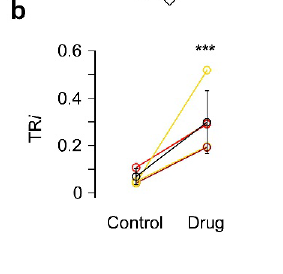


mglur6: 2>1>3b>4>3a
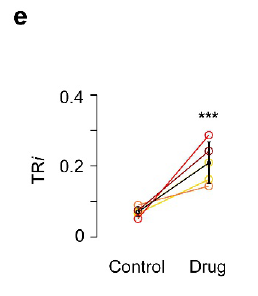

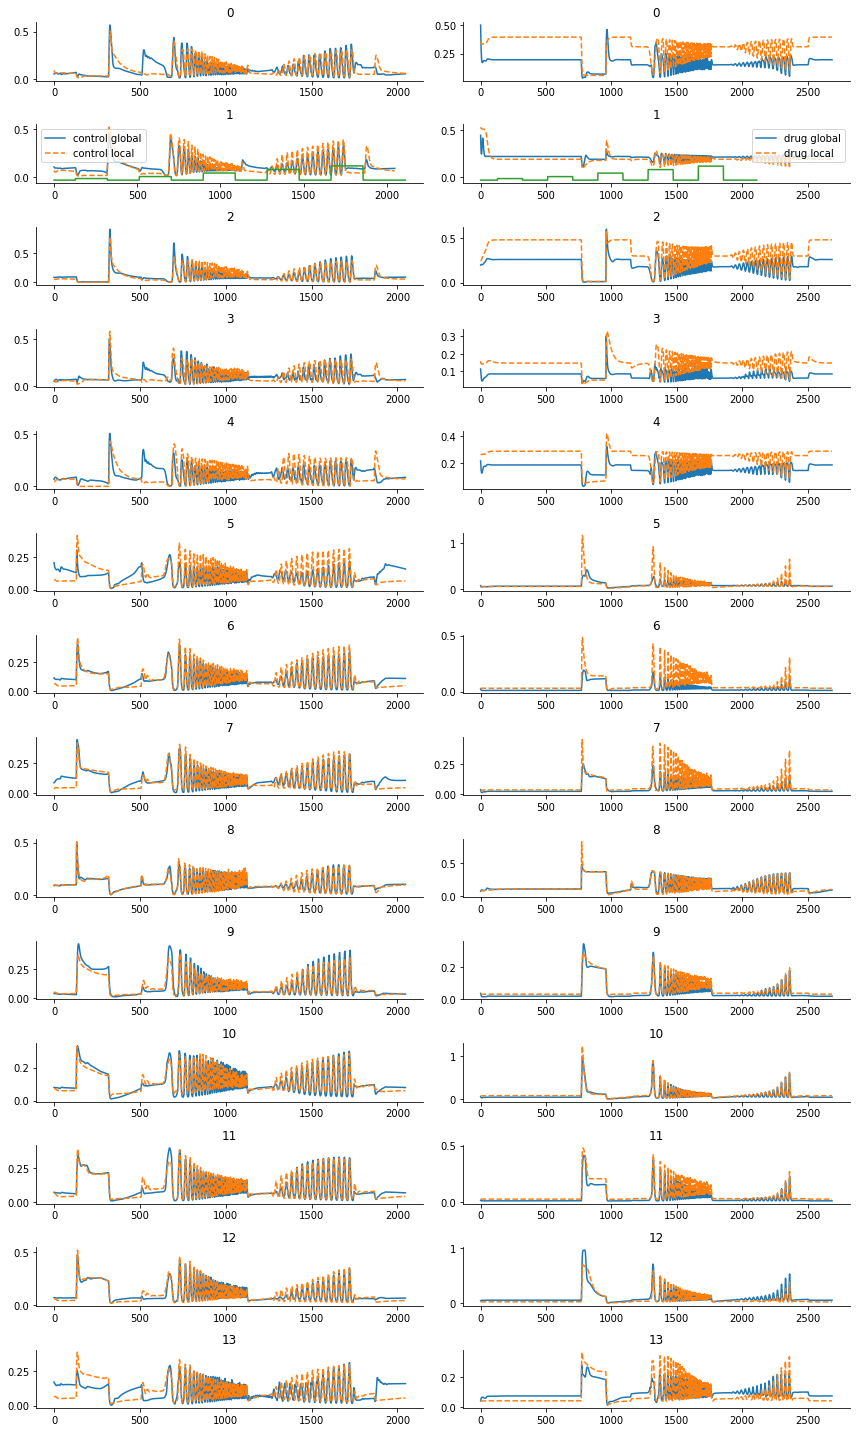

In [119]:
plt.figure(1,figsize=(12,20))
for i in range(14):
    plt.subplot(14,2,i*2+1)
    plt.title(i)
    plt.plot(out_bc_train_unnorm[0][i].detach(), label='control global')
    plt.plot(out_bc_train_unnorm[1][i].detach(), label='control local', ls='--')
    if i==1:
        plt.legend()
        plt.plot(x_test/20)
        
    plt.subplot(14,2,i*2+2)
    plt.title(i)
    plt.plot(drug_mglur6_unnorm[0][i].detach(), label='drug global')
    plt.plot(drug_mglur6_unnorm[1][i].detach(), label='drug local', ls='--')
    
    if i==1:
        plt.legend()
        plt.plot(x_test/20)

plt.tight_layout()
sns.despine()

## GABA blocking

almost local=global per construction. only shift in NL-offset

In [156]:
"""
BCN
"""

model_bcn_drug_gaba = FullBCModel()

model_bcn_drug_gaba.load_state_dict(torch.load(file_path_model+'model.pth'))

<All keys matched successfully>

In [157]:
"""
modify parameter
"""
# blocking ACG-to-BC connection
model_bcn_drug_gaba.log_acg_bc_weight.data  = -torch.ones((14,35))*1e10 

# test sigmoid shift
#model_bcn_drug_gaba.bcn_sigmoid_offset.data =  model_bcn_drug_gaba.bcn_sigmoid_offset.data - mean_global_fb



"""
run model
"""
# returns: y_lnr, lnr_state, y_bcn, bcn_state
out_bcn_drug_gaba = model_bcn_drug_gaba.forward(x_train_tensor)

"""
get unnormalized responses
"""
# final iGluSNFR filter 

drug_gaba_unnorm = [final_transformation(out_bcn_drug_gaba[3]['track_release'],  model_bcn.iglusnfr_kernel),
                       final_transformation(out_bcn_drug_gaba[1]['track_release'],  model_bcn.iglusnfr_kernel)]

"""
calc correlation
"""
corr_drug_gaba = get_corr_train(drug_gaba_unnorm[0].detach(), 
                                drug_gaba_unnorm[1].detach())

0.8202797755072987
0.9426838070509362


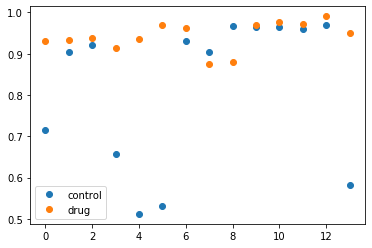

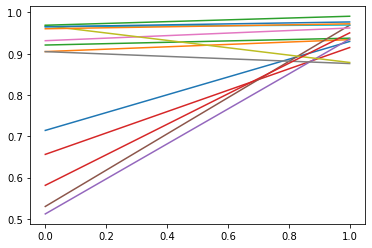

In [158]:
print(np.mean(corr_control))
print(np.mean(corr_drug_gaba))


plt.plot(corr_control,'o',label='control')
plt.plot(corr_drug_gaba,'o', label='drug')
plt.legend()
plt.show()
plt.plot(np.stack([corr_control,corr_drug_gaba]))
plt.show()


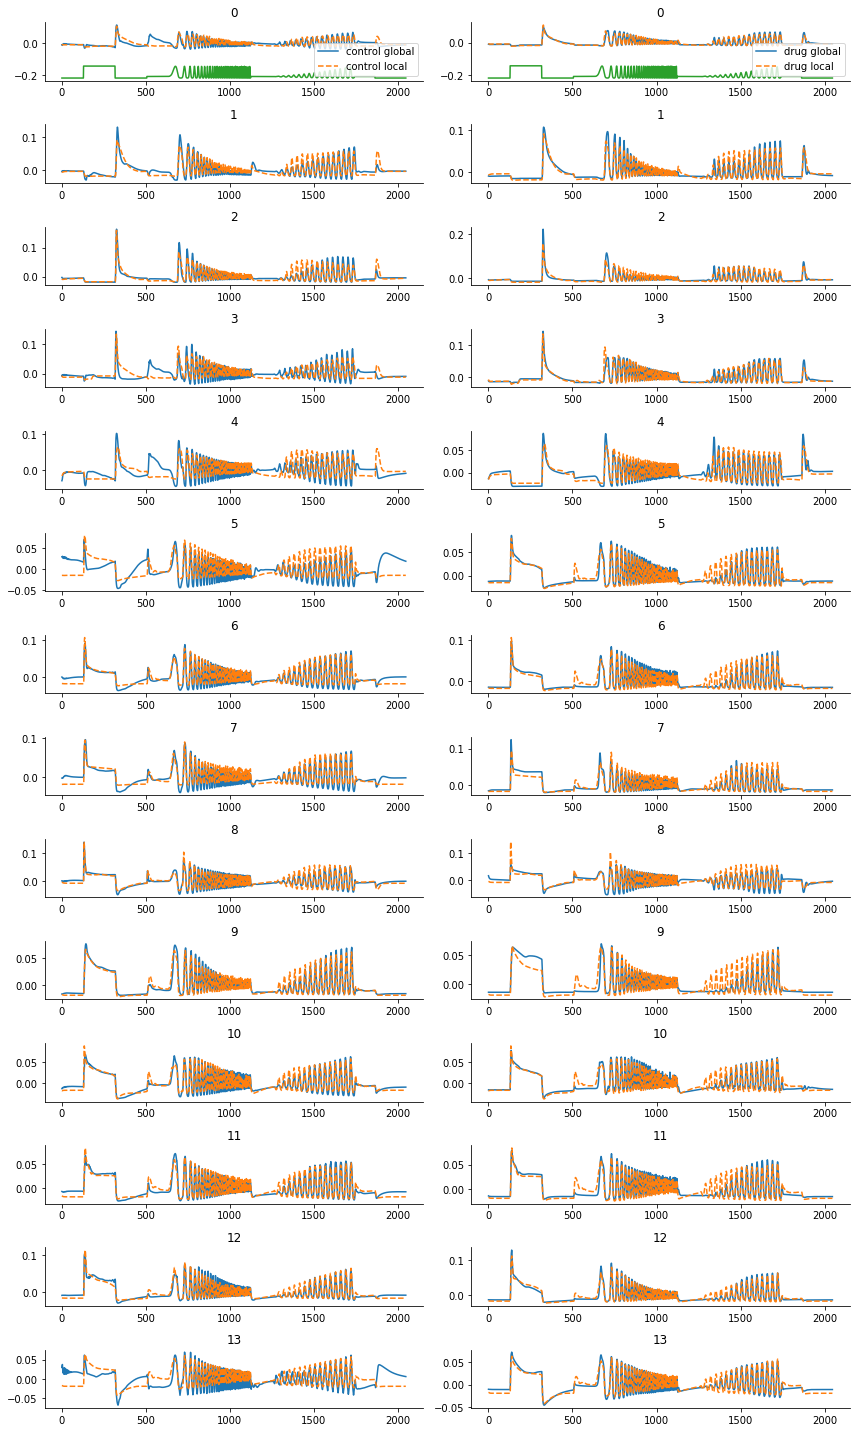

In [73]:
plt.figure(1,figsize=(12,20))
for i in range(14):
    plt.subplot(14,2,i*2+1)
    plt.title(i)
    ## unnormalized
    #plt.plot(out_bc_train_unnorm[0][i].detach(), label='control global')
    #plt.plot(out_bc_train_unnorm[1][i].detach(), label='control local', ls='--')
    
    ## normalized
    plt.plot(out_bcn_train[2][i].detach(), label='control global')
    plt.plot(out_bcn_train[0][i].detach(), label='control local', ls='--')
    if i==0:
        plt.legend()
        plt.plot(chirp/40-0.2)
        
    ####    
    plt.subplot(14,2,i*2+2)
    plt.title(i)
    # unnormalized
    #plt.plot(drug_gaba_unnorm[0][i].detach(), label='drug global')
    #plt.plot(drug_gaba_unnorm[1][i].detach(), label='drug local', ls='--')
    ## normalized
    plt.plot(out_bcn_drug_gaba[2][i].detach(), label='drug global')
    plt.plot(out_bcn_drug_gaba[0][i].detach(), label='drug local', ls='--')
    
    
    if i==0:
        plt.legend()
        plt.plot(chirp/40-0.2)

plt.tight_layout()
sns.despine()

In [134]:
corr_experimental = get_corr_train(X_global,X_local)

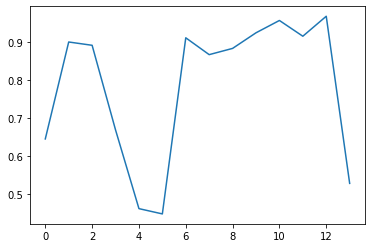

In [135]:
plt.plot(corr_experimental)

In [163]:
corr_control.shape

(14,)

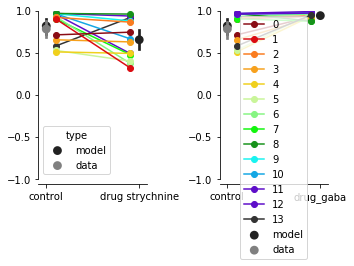

In [432]:
"""
nice for drug correlation
"""
save = False

corr_control_data = get_corr_train(X_local, X_global)

df = pd.DataFrame(columns=['value', 'type', 'setting'])
df['value']=corr_control
df['type']=['model']*14 
df['setting'] = ['control']*14

df4 = pd.DataFrame(columns=['value', 'type', 'setting'])
df4['value']= corr_control_data
df4['type']=['data']*14 
df4['setting'] = ['control']*14


df2 = pd.DataFrame(columns=['value', 'type', 'setting'])
df2['value']= corr_drug_strychnine
df2['type']=['model']*14 
df2['setting'] = ['drug strychnine']*14

df3 = pd.DataFrame(columns=['value', 'type', 'setting'])
df3['value']= corr_drug_gaba
df3['type']=['model']*14
df3['setting'] = ['drug_gaba']*14

df2 = df2.append(df)
df2 = df2.append(df4)

df3 = df3.append(df)
df3 = df3.append(df4)

plt.figure(1,figsize=(5,3))

#plt.suptitle('tonic release index -- OFF cells')

plt.subplot(121)
ax =  sns.pointplot(x='setting',
                    y='value',
                    hue='type',
                    data=df2, 
                    orient='vertical',
                   width=0.8,
                    color='grey',
                    join=False,
                    order=['control','drug strychnine']
                   )
for i in range(14)[::-1]:
    plt.plot([0.1,0.9], 
             np.stack([corr_control,corr_drug_strychnine ])[:,i],
            marker='o',
            color=bc_colors[i],
             label=i
            )

plt.xlabel('')
plt.ylabel('')
plt.yticks([-1,-0.5,0,0.5,1])
#plt.legend()
ax.spines['bottom'].set_position(('outward', 5))
plt.ylim(-1,1)

###################################################
plt.subplot(122)
ax= sns.pointplot(x='setting',
                    y='value',
                    hue='type',
                    data=df3 ,
                    orient='vertical',
                   width=0.8,
                    color='grey',
                    join=False,
                     order=['control','drug_gaba']
                   )

for i in range(0,14):#[::-1]:
    plt.plot([0.1,0.9],
             np.stack([corr_control, corr_drug_gaba])[:,i],
            marker='o',
            ls='-',
            color=bc_colors[i],
            label=i)

plt.ylim(-1,1)
plt.yticks([-1,-0.5,0,0.5,1])
plt.ylabel('TRI')
plt.xlabel('')
sns.despine()
plt.ylabel('')
#plt.legend()
plt.tight_layout()
ax.spines['bottom'].set_position(('outward', 5))
plt.legend()

if save:
    filepath = '../../BC_mechanistic/presenting/fig4/'
    filename = 'corr_drug_dummy_colorcode'
    plt.savefig(filepath+filename+'.svg', dpi=300, format='svg',  bbox_inches='tight')
    plt.savefig(filepath+filename+'.png', dpi=300, format='png',  bbox_inches='tight')
    


In [399]:
    
p1 = ttest_rel(corr_control, corr_drug_strychnine)
p2 = ttest_rel(corr_control, corr_drug_gaba)

print(p1)
print(p2)

Ttest_relResult(statistic=2.3436355542652505, pvalue=0.035646340737563745)
Ttest_relResult(statistic=-2.536283900684909, pvalue=0.024828313402988654)


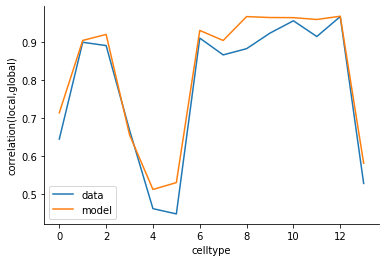

In [177]:
plt.plot(get_corr_train(X_local, X_global), label='data')
plt.plot(corr_control, label='model')
plt.xlabel('celltype')
plt.ylabel('correlation(local,global)')
sns.despine()
plt.legend()